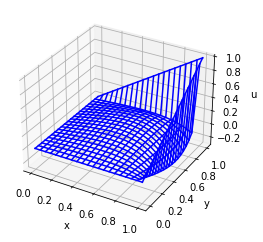

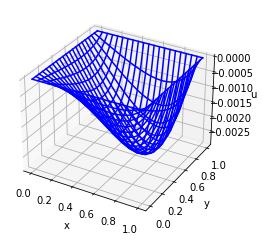

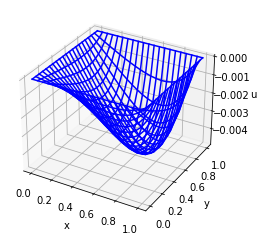

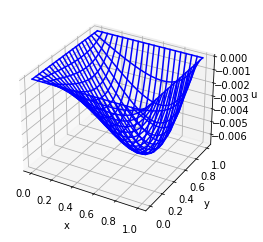

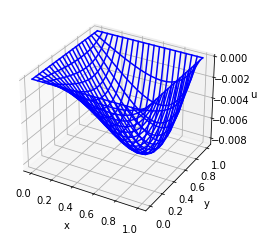

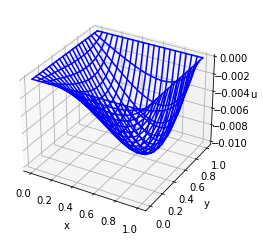

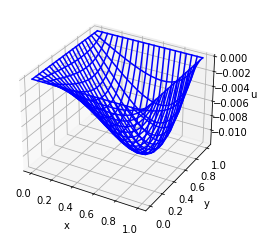

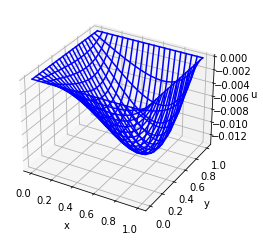

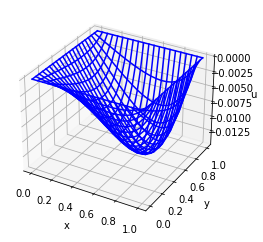

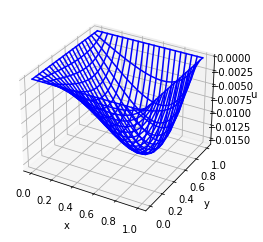

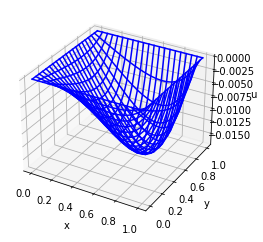

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


In [4]:
# %matplotlib notebook

import sympy as sym
import math
import numpy as np
import matplotlib.pyplot as plt

# Initial data
a = 1
b = 1
eps = 0.001
L = 20
M = 20
T = 10
l1 = 1
l2 = 1
l3 = 1
h1 = l1 / L
h2 = l2 / M
tau = l3 / T

x = sym.symbols('x')
y = sym.symbols('y')
t = sym.symbols('t')
f = - x * y * sym.sin(t)

u_mesh = np.zeros((L + 1, M + 1, T + 1))  # Finite-difference mesh


def tridiagonal_matrix_algorithm(a, b, c, d, n):
    p = np.zeros([n])
    q = np.zeros([n])
    x = np.zeros([n])
    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]
    for i in range(1, n):
        p[i] = -c[i] / (b[i] + a[i]*p[i - 1])
        q[i] = (d[i] - a[i]*q[i - 1]) / (b[i] + a[i]*p[i - 1])

    x[n - 1] = q[n - 1]
    for i in range(n - 2, -1, -1):
        x[i] = p[i]*x[i + 1] + q[i]
    return x


def draw_u(u, layer):
    x = [h1 * i for i in range(L + 1)] * (M + 1)

    y = np.zeros((L + 1) * (M + 1))
    i = 0
    j = 0
    while i < (L + 1) * (M + 1):
        y[i] = h2 * j
        i += 1
        if i % (L + 1) == 0:
            j += 1

    z = np.zeros((L + 1) * (M + 1))
    k = 0
    n = 0
    for i in range((L + 1) * (M + 1)):
        z[i] = u[n][k][layer]
        n += 1
        if n % (L + 1) == 0:
            n = 0
            k += 1

    x2 = np.zeros((L + 1) * (M + 1))
    i = 0
    j = 0
    while i < (L + 1) * (M + 1):
        x2[i] = h1 * j
        i += 1
        if i % (M + 1) == 0:
            j += 1

    y2 = [h2 * i for i in range(M + 1)] * (L + 1)

    z2 = np.zeros((L + 1) * (M + 1))
    i = 0
    j = 0
    r = 0
    while r < (L + 1) * (M + 1):
        z2[r] = z[i * (L + 1) + j]
        r += 1
        i += 1
        if r % (M + 1) == 0:
            i = 0
            j += 1

    ax = plt.axes(projection="3d")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    for i in range(M + 1):
        ax.plot3D(x[(L + 1) * i:(L + 1) * (i + 1)], y[(L + 1) * i:(L + 1) * (i + 1)], z[(L + 1) * i:(L + 1) * (i + 1)],
                  'blue')
    for i in range(L + 1):
        ax.plot3D(x2[(M + 1) * i:(M + 1) * (i + 1)], y2[(M + 1) * i:(M + 1) * (i + 1)],
                  z2[(M + 1) * i:(M + 1) * (i + 1)], 'blue')
    plt.show()
#     СПИДРАН ПО МАЙНКРАФТУ ПОЕХАЛИ
    


def create_u(u):

    for i in range(L + 1):  # Initial condition
        for j in range(M + 1):
            u[i][j][0] = i * h1 * j * h2

    # Boundary conditions
    for i in range(L + 1):
        for k in range(1, T + 1):
            u[i][0][k] = 0

    for j in range(M + 1):
        for k in range(1, T + 1):
            u[L][j][k] = - u[L - 1][j][k] / (h1 - 1)


    for j in range(M + 1):
        for k in range(1, T + 1):
            u[0][j][k] = 0

    for i in range(L + 1):
        for k in range(1, T + 1):
            u[i][M][k] = - u[i][M - 1][k] / (h2 - 1)

    u_half = np.zeros((L + 1, M + 1, T + 1))
    for k in range(T + 1):
        # (n + 1/2) layer
        for j in range(1, M):
            A1 = []
            B1 = []
            C1 = []
            F1 = []
            for i in range(1, L):
                A1.append(tau / (2*h1**2))
                B1.append(-(1 + (tau / h1**2)))
                C1.append(tau / (2*h1**2))
                F1.append((-tau/2) * f.subs([(x, i*h1), (y, j*h2), (t, tau*(k + 1/2))])
                         - (tau/(2*h2**2)) * (u[i][j+1][k] - 2*u[i][j][k] + u[i][j-1][k]) - u[i][j][k])
            mass1 = tridiagonal_matrix_algorithm(A1, B1, C1, F1, L - 1)
            for i in range(1, L):
                u_half[i][j][k] = mass1[i - 1]

        # (n + 1) layer
        for i in range(1, L):
            A2 = []
            B2 = []
            C2 = []
            F2 = []
            for j in range(1, M):
                A2.append(tau / (2*h2**2))
                B2.append(-(1 + (tau / h2**2)))
                C2.append(tau / (2*h2**2))
                F2.append((-tau/2) * f.subs([(x, i*h1), (y, j*h2), (t, tau*(k + 1/2))])
                         - (tau/(2*h1**2)) * (u_half[i-1][j][k] - 2*u_half[i][j][k] + u_half[i+1][j][k]) - u_half[i][j][k])
            mass2 = tridiagonal_matrix_algorithm(A2, B2, C2, F2, M - 1)
            for j in range(1, M):
                u[i][j][k] = mass2[j - 1]

#     print(np.around(u, 1))
    for layer in range(T + 1):
        draw_u(u, layer)


create_u(u_mesh)
for i in range(T + 1):
    print((i) * tau)